# Stock/Index Prediction with LSTM

In this notebook, stock/index prediction is performed using data extracted from Yahoo Finance, different features used in finance are created, and a LSMT-based network is trained and tested.

In [1]:
#We import necessary libraries
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset
from utils.functions import *
import optuna


We imported the data from yahoo finance

In [2]:
#We downloaded the data using yahoo finance
start_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2024, 1, 1)# dt.datetime.now()


# Energy Stocks
energy_stocks = ['ENPH', 'FSLR', 'SHEL','XOM', 'CVX','BP', 'TTE', 'NEE', 'DUK', ] #
stock_data = {stock: get_data(stock, start_date, end_date) for stock in energy_stocks}

# Energy Indices
energy_indices = ['^GSPE', 'ICLN']
index_data = {index: get_data(index, start_date, end_date) for index in energy_indices}


index_data = pd.DataFrame.from_dict(index_data)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Feature engineering
In addition to the stock, we include variables typically used in finance.
Note that these new features have been obtained causally, so there is no data leakage.

In [3]:
df_data = pd.DataFrame.from_dict(stock_data)
df_data = pd.concat([df_data, index_data],axis=1)


#Simple Moving Average 
df_sma_5 = compute_sma(df_data, 5)
df_sma_20 = compute_sma(df_data, 20)
# Exponential Moving Average
df_ema_5 = compute_ema(df_data, 5)
 #Relative Strength Index 
df_rsi_14 = compute_rsi(df_data, 14)
#Moving Average Convergence Divergence 
df_macd, df_macd_signal = compute_macd(df_data)
#Volatility (Standard Deviation or Bollinger Bands)
df_bb_upper, df_bb_lower = compute_bollinger_bands(df_data, 20)

df_data[df_sma_5.columns] = df_sma_5
df_data[df_sma_20.columns] = df_sma_20
df_data[df_ema_5.columns] = df_ema_5
df_data[df_rsi_14.columns] = df_rsi_14
df_data[df_macd.columns] = df_macd
df_data[df_macd_signal.columns] = df_macd_signal
df_data[df_bb_upper.columns] = df_bb_upper
df_data[df_bb_lower.columns] = df_bb_lower


df_dates = add_date_features(df_data) 

df_data[df_dates.columns] = df_dates

df_data.dropna(axis=0, inplace=True)


/tmp/ipykernel_134076/3185020324.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data[df_dates.columns] = df_dates
/tmp/ipykernel_134076/3185020324.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data[df_dates.columns] = df_dates
/tmp/ipykernel_134076/3185020324.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

Below we visualize these new features, in particular the new features for the 'ICLN' target are graphed.
Note that the graphs are for the same variable, but due to the scale of the different features, a subplot has been made.

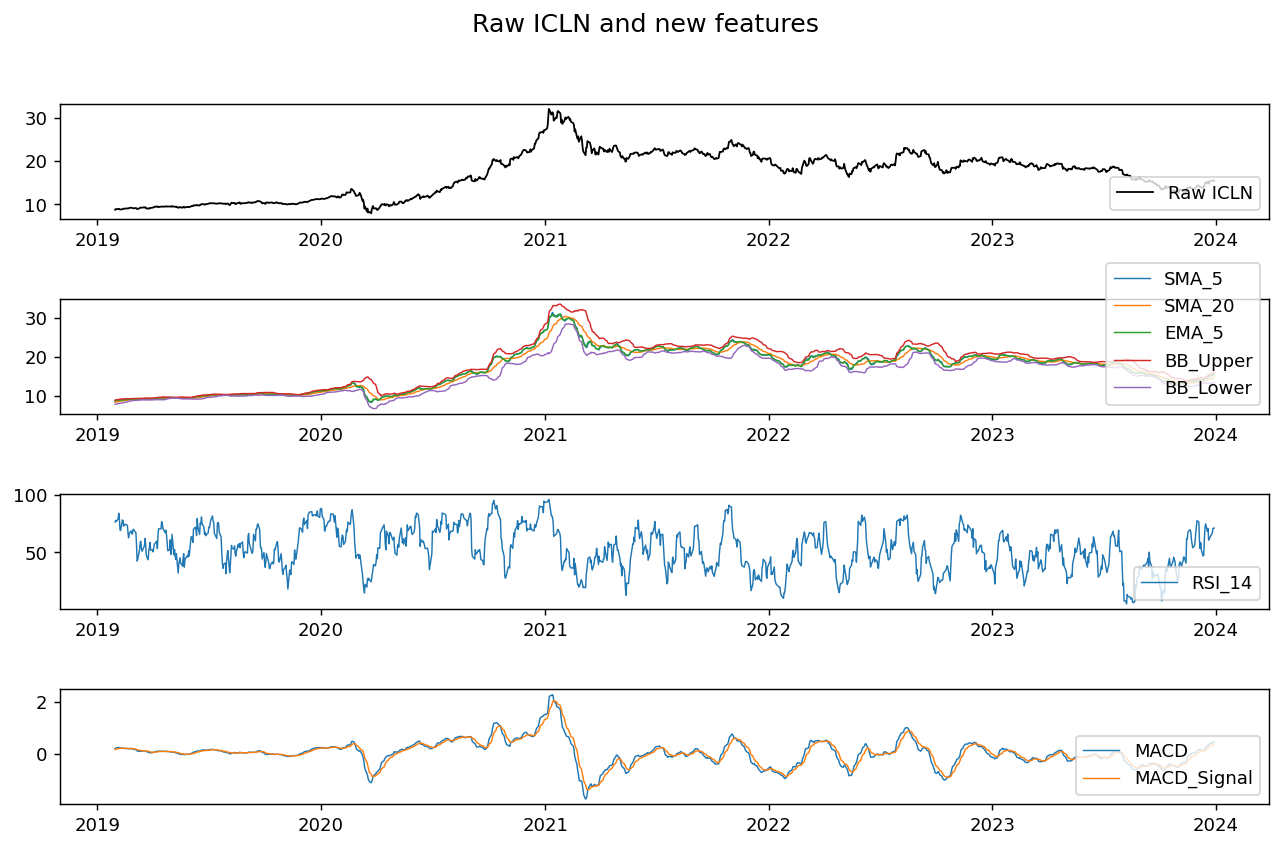

In [4]:
name_target ='ICLN'

fig, ax = plt.subplots(nrows=4,figsize=(12, 7), dpi=130)
plt.suptitle('Raw '+name_target+' and new features', size=14)
ax[0].plot(df_data[name_target], label ='Raw '+name_target, color= 'k',linewidth=1)
ax[1].plot(df_data[name_target+'_SMA_5'], label ='SMA_5', linewidth=0.8)
ax[1].plot(df_data[name_target+'_SMA_20'], label ='SMA_20', linewidth=0.8)
ax[1].plot(df_data[name_target+'_EMA_5'], label ='EMA_5', linewidth=0.8)
ax[1].plot(df_data[name_target+'_BB_Upper'], label ='BB_Upper', linewidth=0.8)
ax[1].plot(df_data[name_target+'_BB_Lower'], label ='BB_Lower', linewidth=0.8)


ax[2].plot(df_data[name_target+'_RSI_14'], label ='RSI_14', linewidth=0.8)
ax[3].plot(df_data[name_target+'_MACD'], label ='MACD', linewidth=0.8)
ax[3].plot(df_data[name_target+'_MACD_Signal'], label ='MACD_Signal', linewidth=0.8)


ax[0].legend(loc=4)
ax[1].legend(loc=4)
ax[2].legend(loc=4)
ax[3].legend(loc=4)
plt.subplots_adjust(hspace=0.7,)

plt.show()

We divide the database into train, validation and test

In [5]:
split_idx_train = int(len(df_data) * 0.6)
split_idx_val = int(len(df_data) * 0.2)


train_df = df_data[:split_idx_train]
val_df = df_data[split_idx_train:split_idx_train + split_idx_val]
test_df = df_data[split_idx_train + split_idx_val:]


print('date range train: {} - {} '.format(train_df.index[0],train_df.index[-1]))
print('date range val: {} - {} '.format(val_df.index[0],val_df.index[-1]))
print('date range test: {} - {} '.format(test_df.index[0],test_df.index[-1]))



date range train: 2019-01-30 00:00:00 - 2022-01-07 00:00:00 
date range val: 2022-01-10 00:00:00 - 2023-01-03 00:00:00 
date range test: 2023-01-04 00:00:00 - 2023-12-29 00:00:00 


We decide which features and target we want to use in the model

In [6]:
#Define the target and features to use
name_target ='ICLN' #
name_features = train_df.columns.to_list() # [ 'TTE ,'ENPH', 'FSLR', 'SHEL' ]#


## Hyperparameters optimisation using Optuna
In the file functions.py, which is imported at the start, we define the LSTM model to be trained. Achieving good results depends heavily on optimising the hyperparameters. In our case, we will use the Optuna library to efficiently search for the optimal parameters for our task.

In [7]:

def objective(trial):

    window_size = trial.suggest_int('window_size', 5, 60) 
    name_scale = trial.suggest_categorical('scaling_method', ['MinMax', 'StandardScaler'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    #Preprocessing
    train_X, train_y, info_dates_train, scaler, idx_target = preprocess_data(train_df, name_target, name_features, window_size, scaler=name_scale)
    val_X, val_y, info_dates_val, _, _ = preprocess_data(val_df, name_target, name_features, window_size, scaler)

    #DataTensor
    train_X_tensor, train_y_tensor = torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)
    val_X_tensor, val_y_tensor = torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32)

    #Dataloader
    train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_X_tensor, val_y_tensor), batch_size=batch_size)

    input_size = train_X.shape[-1]
    trial.set_user_attr('input_size', input_size)


    # Define hyperparameters to optimise
    lstm_hidden_dim =  trial.suggest_int('lstm_hidden_dim', 32, 128) 
    lstm_layers = trial.suggest_int('lstm_layers', 1, 5) 
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)


    model = modelLSTM( input_size=input_size, hidden_layer_size=lstm_hidden_dim, num_layers=lstm_layers)

    loss_function = nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10)
    early_stopping = EarlyStopping(patience=20, min_delta=0.00001)

    
    metrics = {'loss_train': [], 'loss_val': [],
                'mape_train':[], 'mape_val':[],
               'rmse_train':[], 'rmse_val':[]}
    mape_metric = torchmetrics.MeanAbsolutePercentageError()
    rmse_metric = torchmetrics.MeanSquaredError(squared=False)  
    epochs = 100
    trial.set_user_attr('epochs', epochs)

    for epoch in range(epochs):
       
        mape_metric.reset()
        rmse_metric.reset()

        model.train()
        train_loss, train_mape, train_rmse = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimiser.zero_grad()
            y_pred = model(X_batch)  
                  
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
            train_mape += mape_metric(y_pred, y_batch).item() 
            train_rmse += rmse_metric(y_pred, y_batch).item() 

        train_loss /= len(train_loader)
        train_mape /= len(train_loader)
        train_rmse /= len(train_loader)

        metrics['loss_train'].append(train_loss)
        metrics['mape_train'].append(train_mape)
        metrics['rmse_train'].append(train_rmse)


        model.eval()
        val_loss, val_mape, val_rmse = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch) 
                loss = loss_function(y_pred, y_batch)
                val_loss += loss.item()

                val_mape += mape_metric(y_pred, y_batch).item() 
                val_rmse += rmse_metric(y_pred, y_batch).item() 


        val_loss /= len(val_loader)
        val_mape /= len(val_loader)
        val_rmse /= len(val_loader)


        metrics['loss_val'].append(val_loss)
        metrics['mape_val'].append(val_mape)
        metrics['rmse_val'].append(val_rmse)

        scheduler.step(val_loss)
        trial.report(val_loss, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'  Train MAPE: {train_mape:.2f}%, Validation MAPE: {val_mape:.2f}%')
            print(f'  Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')


    return val_loss



In [8]:
#Create and run the Optuna study, minimise the val loss
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler()) #Tree-structured Parzen Estimator
study.optimize(objective, n_trials=20)

[I 2024-10-18 15:16:07,331] A new study created in memory with name: no-name-25ab3478-29bb-489e-b1b6-c7b7297386d3


Epoch 1/100:
  Train Loss: 0.0426, Validation Loss: 0.0124
  Train MAPE: 126.34%, Validation MAPE: 0.19%
  Train RMSE: 0.1879, Validation RMSE: 0.0995
Epoch 11/100:
  Train Loss: 0.0013, Validation Loss: 0.0093
  Train MAPE: 82.82%, Validation MAPE: 0.16%
  Train RMSE: 0.0349, Validation RMSE: 0.0847
Epoch 21/100:
  Train Loss: 0.0004, Validation Loss: 0.0085
  Train MAPE: 45.82%, Validation MAPE: 0.16%
  Train RMSE: 0.0198, Validation RMSE: 0.0821


[I 2024-10-18 15:16:42,827] Trial 0 finished with value: 0.008861528617541938 and parameters: {'window_size': 28, 'scaling_method': 'MinMax', 'batch_size': 16, 'lstm_hidden_dim': 82, 'lstm_layers': 5, 'learning_rate': 0.0006477894253417819}. Best is trial 0 with value: 0.008861528617541938.


Early stopping triggered at epoch 23
Epoch 1/100:
  Train Loss: 1.0327, Validation Loss: 0.5402
  Train MAPE: 1.52%, Validation MAPE: 1.31%
  Train RMSE: 1.0147, Validation RMSE: 0.7349
Epoch 11/100:
  Train Loss: 0.0777, Validation Loss: 0.2271
  Train MAPE: 0.38%, Validation MAPE: 1.30%
  Train RMSE: 0.2772, Validation RMSE: 0.4765
Epoch 21/100:
  Train Loss: 0.0228, Validation Loss: 0.1340
  Train MAPE: 0.21%, Validation MAPE: 0.99%
  Train RMSE: 0.1503, Validation RMSE: 0.3657


[I 2024-10-18 15:16:47,789] Trial 1 finished with value: 0.13469400256872177 and parameters: {'window_size': 28, 'scaling_method': 'StandardScaler', 'batch_size': 128, 'lstm_hidden_dim': 33, 'lstm_layers': 3, 'learning_rate': 0.0008810906401904733}. Best is trial 0 with value: 0.008861528617541938.


Early stopping triggered at epoch 24
Epoch 1/100:
  Train Loss: 0.1889, Validation Loss: 0.2189
  Train MAPE: 1.54%, Validation MAPE: 0.95%
  Train RMSE: 0.4301, Validation RMSE: 0.4650
Epoch 11/100:
  Train Loss: 0.0068, Validation Loss: 0.0229
  Train MAPE: 145.41%, Validation MAPE: 0.26%
  Train RMSE: 0.0801, Validation RMSE: 0.1309
Epoch 21/100:
  Train Loss: 0.0042, Validation Loss: 0.0353
  Train MAPE: 117.48%, Validation MAPE: 0.35%
  Train RMSE: 0.0620, Validation RMSE: 0.1761


[I 2024-10-18 15:17:19,097] Trial 2 finished with value: 0.03503388800059578 and parameters: {'window_size': 34, 'scaling_method': 'MinMax', 'batch_size': 16, 'lstm_hidden_dim': 86, 'lstm_layers': 3, 'learning_rate': 1.4107163553145713e-05}. Best is trial 0 with value: 0.008861528617541938.


Early stopping triggered at epoch 26
Epoch 1/100:
  Train Loss: 1.0433, Validation Loss: 0.8450
  Train MAPE: 1.96%, Validation MAPE: 1.80%
  Train RMSE: 1.0154, Validation RMSE: 0.8958
Epoch 11/100:
  Train Loss: 0.0550, Validation Loss: 0.3091
  Train MAPE: 0.54%, Validation MAPE: 1.07%
  Train RMSE: 0.2266, Validation RMSE: 0.5197
Epoch 21/100:
  Train Loss: 0.0154, Validation Loss: 0.4052
  Train MAPE: 0.27%, Validation MAPE: 1.26%
  Train RMSE: 0.1199, Validation RMSE: 0.6139


[I 2024-10-18 15:17:31,103] Trial 3 finished with value: 0.4047439103679998 and parameters: {'window_size': 25, 'scaling_method': 'StandardScaler', 'batch_size': 16, 'lstm_hidden_dim': 113, 'lstm_layers': 1, 'learning_rate': 2.255159222510012e-05}. Best is trial 0 with value: 0.008861528617541938.


Early stopping triggered at epoch 28
Epoch 1/100:
  Train Loss: 0.1928, Validation Loss: 0.0200
  Train MAPE: 74.40%, Validation MAPE: 0.25%
  Train RMSE: 0.4305, Validation RMSE: 0.1321
Epoch 11/100:
  Train Loss: 0.0013, Validation Loss: 0.0184
  Train MAPE: 137.15%, Validation MAPE: 0.21%
  Train RMSE: 0.0341, Validation RMSE: 0.1085
Epoch 21/100:
  Train Loss: 0.0007, Validation Loss: 0.0329
  Train MAPE: 95.18%, Validation MAPE: 0.29%
  Train RMSE: 0.0255, Validation RMSE: 0.1499


[I 2024-10-18 15:18:37,712] Trial 4 finished with value: 0.03409952962717328 and parameters: {'window_size': 54, 'scaling_method': 'MinMax', 'batch_size': 16, 'lstm_hidden_dim': 70, 'lstm_layers': 5, 'learning_rate': 0.0001369860824349992}. Best is trial 0 with value: 0.008861528617541938.


Early stopping triggered at epoch 27
Epoch 1/100:
  Train Loss: 0.0851, Validation Loss: 0.0062
  Train MAPE: 140.26%, Validation MAPE: 0.12%
  Train RMSE: 0.2902, Validation RMSE: 0.0723
Epoch 11/100:
  Train Loss: 0.0018, Validation Loss: 0.0048
  Train MAPE: 91.17%, Validation MAPE: 0.13%
  Train RMSE: 0.0415, Validation RMSE: 0.0684
Epoch 21/100:
  Train Loss: 0.0005, Validation Loss: 0.0084
  Train MAPE: 46.19%, Validation MAPE: 0.17%
  Train RMSE: 0.0231, Validation RMSE: 0.0900


[I 2024-10-18 15:18:42,627] Trial 5 finished with value: 0.006429193657822907 and parameters: {'window_size': 6, 'scaling_method': 'MinMax', 'batch_size': 64, 'lstm_hidden_dim': 42, 'lstm_layers': 5, 'learning_rate': 0.001669669607803186}. Best is trial 5 with value: 0.006429193657822907.


Early stopping triggered at epoch 28
Epoch 1/100:
  Train Loss: 0.0548, Validation Loss: 0.0344
  Train MAPE: 196.59%, Validation MAPE: 0.37%
  Train RMSE: 0.2298, Validation RMSE: 0.1789
Epoch 11/100:
  Train Loss: 0.0010, Validation Loss: 0.0058
  Train MAPE: 30.91%, Validation MAPE: 0.15%
  Train RMSE: 0.0318, Validation RMSE: 0.0735
Epoch 21/100:
  Train Loss: 0.0006, Validation Loss: 0.0043
  Train MAPE: 3.53%, Validation MAPE: 0.13%
  Train RMSE: 0.0242, Validation RMSE: 0.0645
Epoch 31/100:
  Train Loss: 0.0005, Validation Loss: 0.0038
  Train MAPE: 7.60%, Validation MAPE: 0.12%
  Train RMSE: 0.0222, Validation RMSE: 0.0596
Epoch 41/100:
  Train Loss: 0.0005, Validation Loss: 0.0035
  Train MAPE: 10.14%, Validation MAPE: 0.11%
  Train RMSE: 0.0213, Validation RMSE: 0.0571
Epoch 51/100:
  Train Loss: 0.0004, Validation Loss: 0.0031
  Train MAPE: 10.56%, Validation MAPE: 0.11%
  Train RMSE: 0.0199, Validation RMSE: 0.0542
Epoch 61/100:
  Train Loss: 0.0004, Validation Loss: 0.0033

[I 2024-10-18 15:19:17,625] Trial 6 finished with value: 0.0031980020659310477 and parameters: {'window_size': 51, 'scaling_method': 'MinMax', 'batch_size': 32, 'lstm_hidden_dim': 123, 'lstm_layers': 1, 'learning_rate': 0.00010481096137741513}. Best is trial 6 with value: 0.0031980020659310477.
[I 2024-10-18 15:19:17,800] Trial 7 pruned. 


Early stopping triggered at epoch 68


[I 2024-10-18 15:19:18,142] Trial 8 pruned. 
[I 2024-10-18 15:19:19,549] Trial 9 pruned. 


Epoch 1/100:
  Train Loss: 0.3122, Validation Loss: 0.0040
  Train MAPE: 320.17%, Validation MAPE: 0.10%
  Train RMSE: 0.4348, Validation RMSE: 0.0587
Epoch 11/100:
  Train Loss: 0.0009, Validation Loss: 0.0053
  Train MAPE: 36.74%, Validation MAPE: 0.13%
  Train RMSE: 0.0300, Validation RMSE: 0.0671


[I 2024-10-18 15:19:31,305] Trial 10 finished with value: 0.004145945999577331 and parameters: {'window_size': 60, 'scaling_method': 'MinMax', 'batch_size': 32, 'lstm_hidden_dim': 127, 'lstm_layers': 1, 'learning_rate': 0.009533954426559677}. Best is trial 6 with value: 0.0031980020659310477.


Early stopping triggered at epoch 20


[I 2024-10-18 15:19:31,895] Trial 11 pruned. 


Epoch 1/100:
  Train Loss: 0.1116, Validation Loss: 0.0040
  Train MAPE: 353.85%, Validation MAPE: 0.10%
  Train RMSE: 0.3019, Validation RMSE: 0.0572
Epoch 11/100:
  Train Loss: 0.0009, Validation Loss: 0.0019
  Train MAPE: 29.35%, Validation MAPE: 0.07%
  Train RMSE: 0.0290, Validation RMSE: 0.0407
Epoch 21/100:
  Train Loss: 0.0005, Validation Loss: 0.0023
  Train MAPE: 10.11%, Validation MAPE: 0.09%
  Train RMSE: 0.0224, Validation RMSE: 0.0460
Epoch 31/100:
  Train Loss: 0.0003, Validation Loss: 0.0025
  Train MAPE: 13.21%, Validation MAPE: 0.09%
  Train RMSE: 0.0171, Validation RMSE: 0.0482


[I 2024-10-18 15:20:02,765] Trial 12 finished with value: 0.0022828184384187417 and parameters: {'window_size': 47, 'scaling_method': 'MinMax', 'batch_size': 32, 'lstm_hidden_dim': 127, 'lstm_layers': 2, 'learning_rate': 0.006240592684113966}. Best is trial 12 with value: 0.0022828184384187417.


Early stopping triggered at epoch 35


[I 2024-10-18 15:20:03,525] Trial 13 pruned. 


Epoch 1/100:
  Train Loss: 0.1175, Validation Loss: 0.0163
  Train MAPE: 132.62%, Validation MAPE: 0.26%
  Train RMSE: 0.3287, Validation RMSE: 0.1236
Epoch 11/100:
  Train Loss: 0.0009, Validation Loss: 0.0074
  Train MAPE: 59.37%, Validation MAPE: 0.16%
  Train RMSE: 0.0293, Validation RMSE: 0.0849
Epoch 21/100:
  Train Loss: 0.0007, Validation Loss: 0.0065
  Train MAPE: 59.63%, Validation MAPE: 0.15%
  Train RMSE: 0.0259, Validation RMSE: 0.0795


[I 2024-10-18 15:20:17,931] Trial 14 finished with value: 0.006461443978228739 and parameters: {'window_size': 42, 'scaling_method': 'MinMax', 'batch_size': 32, 'lstm_hidden_dim': 101, 'lstm_layers': 2, 'learning_rate': 0.00021663159243564685}. Best is trial 12 with value: 0.0022828184384187417.


Early stopping triggered at epoch 21


[I 2024-10-18 15:20:18,706] Trial 15 pruned. 
[I 2024-10-18 15:20:23,884] Trial 16 pruned. 


Epoch 1/100:
  Train Loss: 0.0338, Validation Loss: 0.0047
  Train MAPE: 195.29%, Validation MAPE: 0.12%
  Train RMSE: 0.1682, Validation RMSE: 0.0611
Epoch 11/100:
  Train Loss: 0.0006, Validation Loss: 0.0017
  Train MAPE: 30.82%, Validation MAPE: 0.07%
  Train RMSE: 0.0237, Validation RMSE: 0.0385
Epoch 21/100:
  Train Loss: 0.0006, Validation Loss: 0.0020
  Train MAPE: 20.23%, Validation MAPE: 0.07%
  Train RMSE: 0.0241, Validation RMSE: 0.0400
Epoch 31/100:
  Train Loss: 0.0004, Validation Loss: 0.0018
  Train MAPE: 25.26%, Validation MAPE: 0.07%
  Train RMSE: 0.0191, Validation RMSE: 0.0382
Epoch 41/100:
  Train Loss: 0.0004, Validation Loss: 0.0017
  Train MAPE: 24.29%, Validation MAPE: 0.07%
  Train RMSE: 0.0192, Validation RMSE: 0.0373
Epoch 51/100:
  Train Loss: 0.0004, Validation Loss: 0.0015
  Train MAPE: 22.72%, Validation MAPE: 0.06%
  Train RMSE: 0.0187, Validation RMSE: 0.0346
Epoch 61/100:
  Train Loss: 0.0004, Validation Loss: 0.0015
  Train MAPE: 23.01%, Validation M

[I 2024-10-18 15:20:56,397] Trial 17 finished with value: 0.0014688422414630103 and parameters: {'window_size': 54, 'scaling_method': 'MinMax', 'batch_size': 32, 'lstm_hidden_dim': 127, 'lstm_layers': 1, 'learning_rate': 0.00029891233428567464}. Best is trial 17 with value: 0.0014688422414630103.


Early stopping triggered at epoch 62


[I 2024-10-18 15:20:57,196] Trial 18 pruned. 


Epoch 1/100:
  Train Loss: 0.1396, Validation Loss: 0.0061
  Train MAPE: 60.76%, Validation MAPE: 0.15%
  Train RMSE: 0.3655, Validation RMSE: 0.0780
Epoch 11/100:
  Train Loss: 0.0029, Validation Loss: 0.0081
  Train MAPE: 130.82%, Validation MAPE: 0.17%
  Train RMSE: 0.0535, Validation RMSE: 0.0872
Epoch 21/100:
  Train Loss: 0.0013, Validation Loss: 0.0092
  Train MAPE: 124.51%, Validation MAPE: 0.18%
  Train RMSE: 0.0353, Validation RMSE: 0.0945


[I 2024-10-18 15:21:06,758] Trial 19 finished with value: 0.008048930671066046 and parameters: {'window_size': 37, 'scaling_method': 'MinMax', 'batch_size': 128, 'lstm_hidden_dim': 59, 'lstm_layers': 4, 'learning_rate': 0.001962846857772632}. Best is trial 17 with value: 0.0014688422414630103.


Early stopping triggered at epoch 22


## Training the best model
After completing the hyperparameter optimisation, we select the best model, retrain it with the optimal hyperparameters (this step can be skipped if the model is saved), and then evaluate it on the test set

In [9]:
best_params = study.best_params
print("Best hyperparameters:", best_params)

window_size = study.best_params['window_size']
name_scale = study.best_params['scaling_method']

#Preprocessing
train_X, train_y, info_dates_train, scaler, idx_target = preprocess_data(train_df, name_target, name_features, window_size, scaler=name_scale)
val_X, val_y, info_dates_val, _, _ = preprocess_data(val_df, name_target, name_features, window_size, scaler)
test_X, test_y, info_dates_test, _, _ = preprocess_data(test_df, name_target, name_features, window_size, scaler)

#DataTensor
train_X_tensor, train_y_tensor = torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)
val_X_tensor, val_y_tensor = torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32)
test_X_tensor, test_y_tensor = torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32)

#Dataloader
train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(TensorDataset(val_X_tensor, val_y_tensor), batch_size=best_params['batch_size'])
test_loader = DataLoader(TensorDataset(test_X_tensor, test_y_tensor), batch_size=best_params['batch_size'])


input_size = study.best_trial.user_attrs['input_size']

best_model = modelLSTM( input_size=input_size, hidden_layer_size=best_params['lstm_hidden_dim'],
                        num_layers=best_params['lstm_layers'])


loss_function = nn.MSELoss()
optimiser = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10)
early_stopping = EarlyStopping(patience=20, min_delta=0.00001)


metrics = {'loss_train': [], 'loss_val': [],
            'mape_train':[], 'mape_val':[],
            'rmse_train':[], 'rmse_val':[]}

mape_metric = torchmetrics.MeanAbsolutePercentageError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)  

epochs = study.best_trial.user_attrs['epochs']
for epoch in range(epochs):
    
    mape_metric.reset()
    rmse_metric.reset()

    best_model.train()
    train_loss, train_mape, train_rmse = 0, 0, 0
    for X_batch, y_batch in train_loader:
        optimiser.zero_grad()
        y_pred = best_model(X_batch)  
                
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
        train_mape += mape_metric(y_pred, y_batch).item() 
        train_rmse += rmse_metric(y_pred, y_batch).item() 

    train_loss /= len(train_loader)
    train_mape /= len(train_loader)
    train_rmse /= len(train_loader)

    metrics['loss_train'].append(train_loss)
    metrics['mape_train'].append(train_mape)
    metrics['rmse_train'].append(train_rmse)



    best_model.eval()
    val_loss, val_mape, val_rmse = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = best_model(X_batch) 
            loss = loss_function(y_pred, y_batch)
            val_loss += loss.item()

            val_mape += mape_metric(y_pred, y_batch).item() 
            val_rmse += rmse_metric(y_pred, y_batch).item() 


    val_loss /= len(val_loader)
    val_mape /= len(val_loader)
    val_rmse /= len(val_loader)


    metrics['loss_val'].append(val_loss)
    metrics['mape_val'].append(val_mape)
    metrics['rmse_val'].append(val_rmse)

    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'  Train MAPE: {train_mape:.2f}%, Validation MAPE: {val_mape:.2f}%')
        print(f'  Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')


metrics_best_model = metrics


Best hyperparameters: {'window_size': 54, 'scaling_method': 'MinMax', 'batch_size': 32, 'lstm_hidden_dim': 127, 'lstm_layers': 1, 'learning_rate': 0.00029891233428567464}
Epoch 1/100:
  Train Loss: 0.0263, Validation Loss: 0.0133
  Train MAPE: 322.31%, Validation MAPE: 0.21%
  Train RMSE: 0.1495, Validation RMSE: 0.1071
Epoch 11/100:
  Train Loss: 0.0007, Validation Loss: 0.0081
  Train MAPE: 39.14%, Validation MAPE: 0.15%
  Train RMSE: 0.0259, Validation RMSE: 0.0785
Epoch 21/100:
  Train Loss: 0.0006, Validation Loss: 0.0023
  Train MAPE: 22.73%, Validation MAPE: 0.08%
  Train RMSE: 0.0238, Validation RMSE: 0.0409
Epoch 31/100:
  Train Loss: 0.0005, Validation Loss: 0.0067
  Train MAPE: 10.84%, Validation MAPE: 0.15%
  Train RMSE: 0.0208, Validation RMSE: 0.0769
Early stopping triggered at epoch 40


In [10]:
#Evaluate

#Real Data
train_real = train_df[name_target][window_size:]
val_real = val_df[name_target][window_size:]
test_real = test_df[name_target][window_size:]

real_combined = pd.concat((train_real, val_real, test_real))


train_pred_scaled = make_predictions(best_model, train_X_tensor)
val_pred_scaled = make_predictions(best_model, val_X_tensor)
test_pred_scaled = make_predictions(best_model, test_X_tensor)



if name_scale == 'Without':

    train_pred_unscaled = train_pred_scaled
    val_pred_unscaled = val_pred_scaled
    test_pred_unscaled = test_pred_scaled

else:
    zeros_shape_scaler = np.zeros((len(train_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = train_pred_scaled
    train_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]

    zeros_shape_scaler = np.zeros((len(val_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = val_pred_scaled
    val_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]


    zeros_shape_scaler = np.zeros((len(test_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = test_pred_scaled
    test_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]



#final metrics:

mape_metric = torchmetrics.MeanAbsolutePercentageError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)  

metrics_final = {
            'rmse_train': rmse_metric(torch.tensor(train_pred_unscaled), torch.tensor(train_real.values)).item(),
            'mape_train': mape_metric(torch.tensor(train_pred_unscaled), torch.tensor(train_real.values)).item(),
            'rmse_val': rmse_metric(torch.tensor(val_pred_unscaled), torch.tensor(val_real.values)).item(),
            'mape_val': mape_metric(torch.tensor(val_pred_unscaled), torch.tensor(val_real.values)).item(),
            'rmse_test': rmse_metric(torch.tensor(test_pred_unscaled), torch.tensor(test_real.values)).item(),
            'mape_test': mape_metric(torch.tensor(test_pred_unscaled), torch.tensor(test_real.values)).item(),
            
            
            }
ds = pd.Series(metrics_final)
ds.round(3)


rmse_train    0.423
mape_train    0.018
rmse_val      1.411
mape_val      0.059
rmse_test     0.797
mape_test     0.043
dtype: float64

Finally we graph the results, metrics and losses

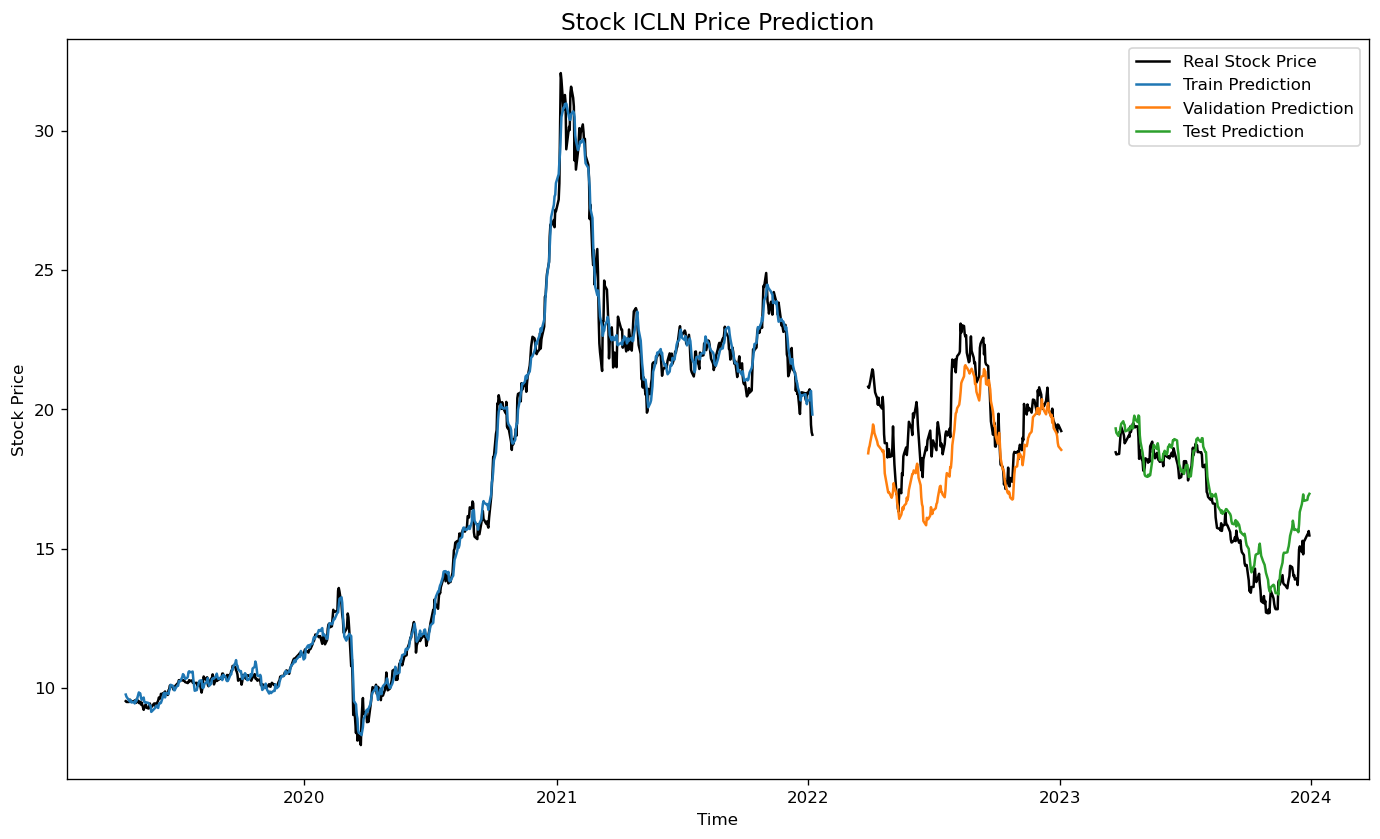

In [11]:
plot_results(real_combined, train_real, val_real, test_real, 
                train_pred_unscaled, val_pred_unscaled, test_pred_unscaled)

## Visualizing results during hyperparameter optimisation

In [12]:
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.visualization import plot_contour, plot_slice
import plotly

In [13]:
# Plot optimization history
optimization_history_plot = plot_optimization_history(study)
optimization_history_plot.show()

# Plot parameter importances
param_importances_plot = plot_param_importances(study)
param_importances_plot.show()

# Plot contour of parameters
#contour_plot = plot_contour(study, params=['learning_rate', 'n_layers'])
#contour_plot.show()

# Plot slice of parameters
slice_plot = plot_slice(study, params=['learning_rate', 'lstm_layers', 'lstm_hidden_dim'])
slice_plot.show()

In [14]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=metrics_best_model['loss_train'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(y=metrics_best_model['loss_val'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss | Best Model', xaxis_title='Epoch', yaxis_title='Loss')
fig.update_yaxes(type="log")
fig.show()

# Plot MMSE for each trial
rmse_values = [np.sqrt(trial.value) for trial in study.trials if trial.value is not None]
fig = go.Figure(data=go.Scatter(y=rmse_values, mode='markers'))
fig.update_layout(title='MSE for Each Trial', xaxis_title='Trial', yaxis_title='MSE')
fig.show()